In [209]:
import xarray as xr
import math
from pathlib import Path
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import box
import pandas as pd
import numpy as np

from geocoded_object_extractor import ObjectExtractor
from geocoded_object_extractor.utils import write_cutouts

In [5]:
# The ID of each species will be calculated as a hash value of the species name
# Set a range limit when converting species labels to hashes values
HASH_RANGE_LIMIT = 1e12

def hash_id(species_name):
    return int(abs(hash(species_name)) % HASH_RANGE_LIMIT)

# Calculate the probability of collision for the given number of species
n = 50 # Assumed total number of species
probability_of_collision = 1 - math.exp(-n * (n - 1) / (2 * HASH_RANGE_LIMIT))
print(f'Possibility of has collision {probability_of_collision}')

Possibility of has collision 1.224999990334652e-09


## Part 1: Merge label data

We acquired the label data from three sources:
- `Tree_location1.gpkg`: The one we got from the beginning of the XAI4GEO project
- `Tree_location2_Herb_Al.gpkg`: The one manually labeled by the Caroline
- `Tree_locationJune24.gpkg`: The one labeled by Alexandra

In this part, we will merge these three datasets into one. The following modifications will be applied:
1. We will unfiy the columns to ['ID', 'ESPECIE', 'TYPO', 'geometry'] by renaming and dropping columns.
2. We will generate an unique ID per species based on the shortened (12-digits) hash value the species name.
3. We will fill the missing values in the 'ESPECIE' and 'TYPO' columns in `Tree_location1.gpkg` by cross comparing common instances with `Tree_locationJune24.gpkg`.


In [6]:
# path_zarr = '../../../../data/cleaned_data/all_cutouts'

data_path = Path('/home/oku/Developments/XAI4GEO/data/brazil_data/')
image_path = data_path / 'original_data/PNM/PROCESSADOS/Map1_Orthomosaic_export_SatJun10172428194829.tif'

tree_locations_path1 = data_path / 'Tree_location1.gpkg' # original label data
tree_locations_path2 = data_path / 'Tree_location2_Herb_Al.gpkg' # two new labels marked by caroline
tree_locations_path3 = data_path / 'Tree_locationJune24.gpkg' # Many new labels marked by alexandra on june 24


There are three species marked in `Tree_location1.gpkg`:

One species name and tyoe name is missing. This species is marked in circle. When cross compare with labels in `Tree_locationJune24.gpkg`, one overlap can be found with `N CIENTIFICO`: `Syagrus romanzoffiana`, `CLASSIFICACAO`: `nativa`. Therefore, we set the `ESPECIE` to `Syagrus romanzoffiana` and `TIPO` to `nativa`.

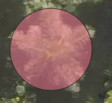 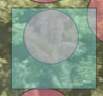


In [8]:
# Modify dataset 1

tree_locations1 = gpd.read_file(tree_locations_path1)
tree_locations1_mod = tree_locations1.copy()

# Set the geometry of all circles to their bounds
def _is_round(row, num_vertex=10):
    # Polygons with >num_vertex vertex are considered to be round
    return len(list(row["geometry"].exterior.coords)) > num_vertex


mask = tree_locations1_mod.apply(_is_round, axis=1)
tree_locations1_mod.loc[mask, "geometry"] = tree_locations1_mod.loc[
    mask, "geometry"
].apply(lambda x: box(*x.bounds))


# Modify the species and type
tree_locations1_mod["ESPECIE"] = tree_locations1_mod["ESPECIE"].replace(
    ["", " ", None], value="Syagrus romanzoffiana"
)
tree_locations1_mod["TIPO"] = tree_locations1_mod["TIPO"].replace(
    ["", " ", None], value="nativa"
)


# Generate the ID from the species name
tree_locations1_mod["ID"] = tree_locations1_mod["ESPECIE"].apply(hash_id)

# Drop SELECIONADA PROJETO
tree_locations1_mod = tree_locations1_mod.drop(columns=["SELECIONADA PROJETO"])

tree_locations1_mod

,ID,ESPECIE,TIPO,geometry
0,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331065.955 7366756.421, 331065.955 7..."
1,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331068.069 7366779.140, 331068.069 7..."
2,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331075.623 7366793.023, 331075.623 7..."
3,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331088.034 7366814.640, 331088.034 7..."
4,267652544512,Syagrus romanzoffiana,nativa,"POLYGON ((331078.417 7366782.807, 331078.417 7..."
5,267652544512,Syagrus romanzoffiana,nativa,"POLYGON ((331073.801 7366791.966, 331073.801 7..."
6,267652544512,Syagrus romanzoffiana,nativa,"POLYGON ((331131.605 7366826.655, 331131.605 7..."
7,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331133.179 7366823.083, 331133.179 7..."
8,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331196.087 7366842.868, 331196.087 7..."
9,318213318656,Archontophoenix cunninghamiana,exotica invasora,"POLYGON ((331196.075 7366878.784, 331196.075 7..."


In [9]:
# Modify dataset 2

tree_locations2 = gpd.read_file(tree_locations_path2)
tree_locations2_mod = tree_locations2.copy()

# Generate the ID from the species name
tree_locations2_mod['ID'] = tree_locations2_mod['ESPECIE'].apply(hash_id)

# Drop SELECIONADA PROJETO
tree_locations2_mod = tree_locations2_mod.drop(columns=['SELECIONADA PROJETO'])

tree_locations2_mod

,ID,ESPECIE,TIPO,geometry
0,928764938240,Cecropia sp,nativa,"POLYGON ((331226.579 7366811.269, 331226.579 7..."
1,928764938240,Cecropia sp,nativa,"POLYGON ((331223.948 7366826.609, 331223.948 7..."
2,928764938240,Cecropia sp,nativa,"POLYGON ((331271.282 7366806.118, 331271.282 7..."
3,928764938240,Cecropia sp,nativa,"POLYGON ((331276.825 7366758.672, 331276.825 7..."
4,928764938240,Cecropia sp,nativa,"POLYGON ((331303.054 7366747.419, 331303.054 7..."
5,928764938240,Cecropia sp,nativa,"POLYGON ((331288.890 7366753.129, 331288.890 7..."
6,928764938240,Cecropia sp,nativa,"POLYGON ((331338.100 7366807.994, 331338.100 7..."
7,928764938240,Cecropia sp,nativa,"POLYGON ((331207.040 7366755.257, 331207.040 7..."
8,928764938240,Cecropia sp,nativa,"POLYGON ((331237.412 7366742.520, 331237.412 7..."
9,928764938240,Cecropia sp,nativa,"POLYGON ((331243.850 7366754.529, 331243.850 7..."


In [10]:
# Modify dataset 3

tree_locations3 = gpd.read_file(tree_locations_path3)
tree_locations3_mod = tree_locations3.copy()

# Generate the ID from the species name
tree_locations3_mod['ID'] = tree_locations3_mod['N CIENTIFICO'].apply(hash_id)

# Drop N POPULAR
tree_locations3_mod = tree_locations3_mod.drop(columns=['N POPULAR'])

# Rename the columns
tree_locations3_mod = tree_locations3_mod.rename(columns={'N CIENTIFICO': 'ESPECIE', 'CLASSIFICACAO': 'TIPO'})

# Sort the columns
tree_locations3_mod = tree_locations3_mod[['ID', 'ESPECIE', 'TIPO', 'geometry']]

tree_locations3_mod

,ID,ESPECIE,TIPO,geometry
0,245146887168,Pinus elliottii,exotica invasora,"POLYGON ((331123.404 7366676.494, 331123.404 7..."
1,245146887168,Pinus elliottii,exotica invasora,"POLYGON ((331129.607 7366683.130, 331129.607 7..."
2,245146887168,Pinus elliottii,exotica invasora,"POLYGON ((331138.238 7366685.082, 331138.238 7..."
3,245146887168,Pinus elliottii,exotica invasora,"POLYGON ((331147.369 7366690.461, 331147.369 7..."
4,245146887168,Pinus elliottii,exotica invasora,"POLYGON ((331161.487 7366696.967, 331161.487 7..."
5,245146887168,Pinus elliottii,exotica invasora,"POLYGON ((331176.300 7366703.343, 331176.300 7..."
6,91277344256,Cunninghamia lanceolata,exotica invasora,"POLYGON ((331194.788 7366707.257, 331194.788 7..."
7,236959227904,Euterpe edulis,nativa ameaçada de extinção,"POLYGON ((331189.052 7366712.159, 331189.052 7..."
8,236959227904,Euterpe edulis,nativa ameaçada de extinção,"POLYGON ((331188.336 7366716.670, 331188.336 7..."
9,236959227904,Euterpe edulis,nativa ameaçada de extinção,"POLYGON ((331180.659 7366721.940, 331180.659 7..."


In [13]:
# merge the datasets
tree_labels = gpd.GeoDataFrame(
    pd.concat([tree_locations1_mod, tree_locations2_mod, tree_locations3_mod], ignore_index=True)
)

# Sort by ID
tree_labels = tree_labels.sort_values(by='ID')

tree_labels

,ID,ESPECIE,TIPO,geometry
61,91277344256,Cunninghamia lanceolata,exotica invasora,"POLYGON ((331076.007 7366684.019, 331076.007 7..."
55,91277344256,Cunninghamia lanceolata,exotica invasora,"POLYGON ((331194.788 7366707.257, 331194.788 7..."
77,100373655296,Libidibia ferrea,nativa do Brasil,"POLYGON ((331168.330 7366891.811, 331168.330 7..."
80,143965381632,Paubrasilia echinata,nativa do Brasil ameaçada de extinção,"POLYGON ((331253.865 7366907.773, 331253.865 7..."
101,143965381632,Paubrasilia echinata,nativa do Brasil ameaçada de extinção,"POLYGON ((331239.036 7366917.375, 331239.036 7..."
...,...,...,...,...
38,928764938240,Cecropia sp,nativa,"POLYGON ((331207.040 7366755.257, 331207.040 7..."
39,928764938240,Cecropia sp,nativa,"POLYGON ((331237.412 7366742.520, 331237.412 7..."
34,928764938240,Cecropia sp,nativa,"POLYGON ((331276.825 7366758.672, 331276.825 7..."
64,997207531008,Anadenanthera colubrina,nativa,"POLYGON ((331055.252 7366730.799, 331055.252 7..."


<Axes: >

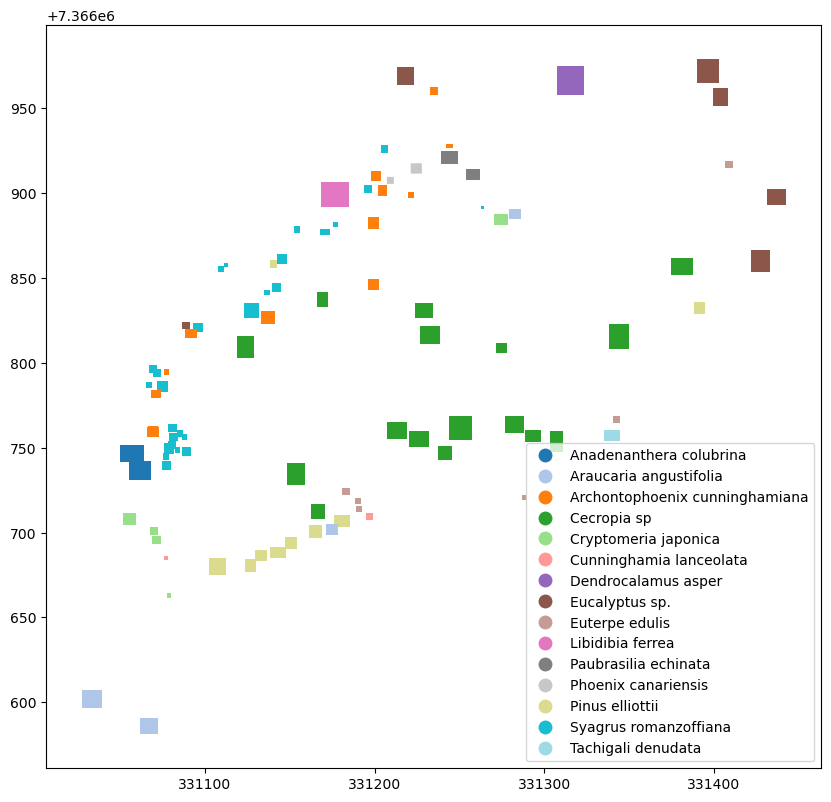

In [19]:
# visualize the tree labels
tree_labels.plot(column='ESPECIE', legend=True, cmap='tab20', figsize=(10, 15), legend_kwds={'loc': 'lower right'})

In [20]:
# export to gpkg
tree_labels.to_file(data_path / 'Tree_labels_merged' / 'tree_labels_merged.gpkg')

# export to shp
tree_labels.to_file(data_path / 'Tree_labels_merged' / 'tree_labels_merged.shp')


## Part 2: make cutouts from UAV images

In [21]:
data_path = Path('/home/oku/Developments/XAI4GEO/data/brazil_data/')
image_path = data_path / 'original_data/PNM/PROCESSADOS/Map1_Orthomosaic_export_SatJun10172428194829.tif'
tree_labels_path = data_path / 'Tree_labels_merged' / 'tree_labels_merged.gpkg'

In [22]:
tree_labels = gpd.read_file(tree_labels_path)
tree_labels

,ID,ESPECIE,TIPO,geometry
0,91277344256,Cunninghamia lanceolata,exotica invasora,"POLYGON ((331076.007 7366684.019, 331076.007 7..."
1,91277344256,Cunninghamia lanceolata,exotica invasora,"POLYGON ((331194.788 7366707.257, 331194.788 7..."
2,100373655296,Libidibia ferrea,nativa do Brasil,"POLYGON ((331168.330 7366891.811, 331168.330 7..."
3,143965381632,Paubrasilia echinata,nativa do Brasil ameaçada de extinção,"POLYGON ((331253.865 7366907.773, 331253.865 7..."
4,143965381632,Paubrasilia echinata,nativa do Brasil ameaçada de extinção,"POLYGON ((331239.036 7366917.375, 331239.036 7..."
...,...,...,...,...
97,928764938240,Cecropia sp,nativa,"POLYGON ((331207.040 7366755.257, 331207.040 7..."
98,928764938240,Cecropia sp,nativa,"POLYGON ((331237.412 7366742.520, 331237.412 7..."
99,928764938240,Cecropia sp,nativa,"POLYGON ((331276.825 7366758.672, 331276.825 7..."
100,997207531008,Anadenanthera colubrina,nativa,"POLYGON ((331055.252 7366730.799, 331055.252 7..."


In [56]:
# Build a dictionary which maps ID to [ESPECIE, TIPO]
id_species_mapping = tree_labels[['ID', 'ESPECIE', 'TIPO']].drop_duplicates().set_index('ID')

# # merge ESPECIE and TIPO to a single column
# id_species_mapping['ESPECIE_TIPO'] = id_species_mapping['ESPECIE'] + ' ' + id_species_mapping['TIPO']
# id_species_mapping = id_species_mapping.drop(columns=['ESPECIE', 'TIPO'])

id_species_mapping = id_species_mapping.to_dict(orient='index')
id_species_mapping


{91277344256: {'ESPECIE': 'Cunninghamia lanceolata',
  'TIPO': 'exotica invasora'},
 100373655296: {'ESPECIE': 'Libidibia ferrea', 'TIPO': 'nativa do Brasil'},
 143965381632: {'ESPECIE': 'Paubrasilia echinata',
  'TIPO': 'nativa do Brasil ameaçada de extinção'},
 236959227904: {'ESPECIE': 'Euterpe edulis',
  'TIPO': 'nativa ameaçada de extinção'},
 245146887168: {'ESPECIE': 'Pinus elliottii', 'TIPO': 'exotica invasora'},
 267652544512: {'ESPECIE': 'Syagrus romanzoffiana', 'TIPO': 'nativa'},
 318213318656: {'ESPECIE': 'Archontophoenix cunninghamiana',
  'TIPO': 'exotica invasora'},
 438312372224: {'ESPECIE': 'Eucalyptus sp.', 'TIPO': 'exotica'},
 516298458112: {'ESPECIE': 'Dendrocalamus asper', 'TIPO': 'exotica'},
 742456632832: {'ESPECIE': 'Phoenix canariensis', 'TIPO': 'exotica'},
 762290529280: {'ESPECIE': 'Cryptomeria japonica', 'TIPO': 'exotica'},
 867124054528: {'ESPECIE': 'Araucaria angustifolia', 'TIPO': 'ameacada'},
 912749161984: {'ESPECIE': 'Tachigali denudata',
  'TIPO': 'na

In [30]:
geoms = tree_labels.geometry
labels = tree_labels['ID']

obj_extr = ObjectExtractor(
    images=[image_path],
    geoms=geoms,
    labels=labels,
    pixel_size=256,
    max_pixel_size=256,
    encode_labels=False
)

labels, transform_params, crs, cutouts = obj_extr.get_cutouts()

/home/oku/miniforge3/envs/xai4geo/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:203: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/oku/miniforge3/envs/xai4geo/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:203: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [35]:
unique_labels = labels.unique()

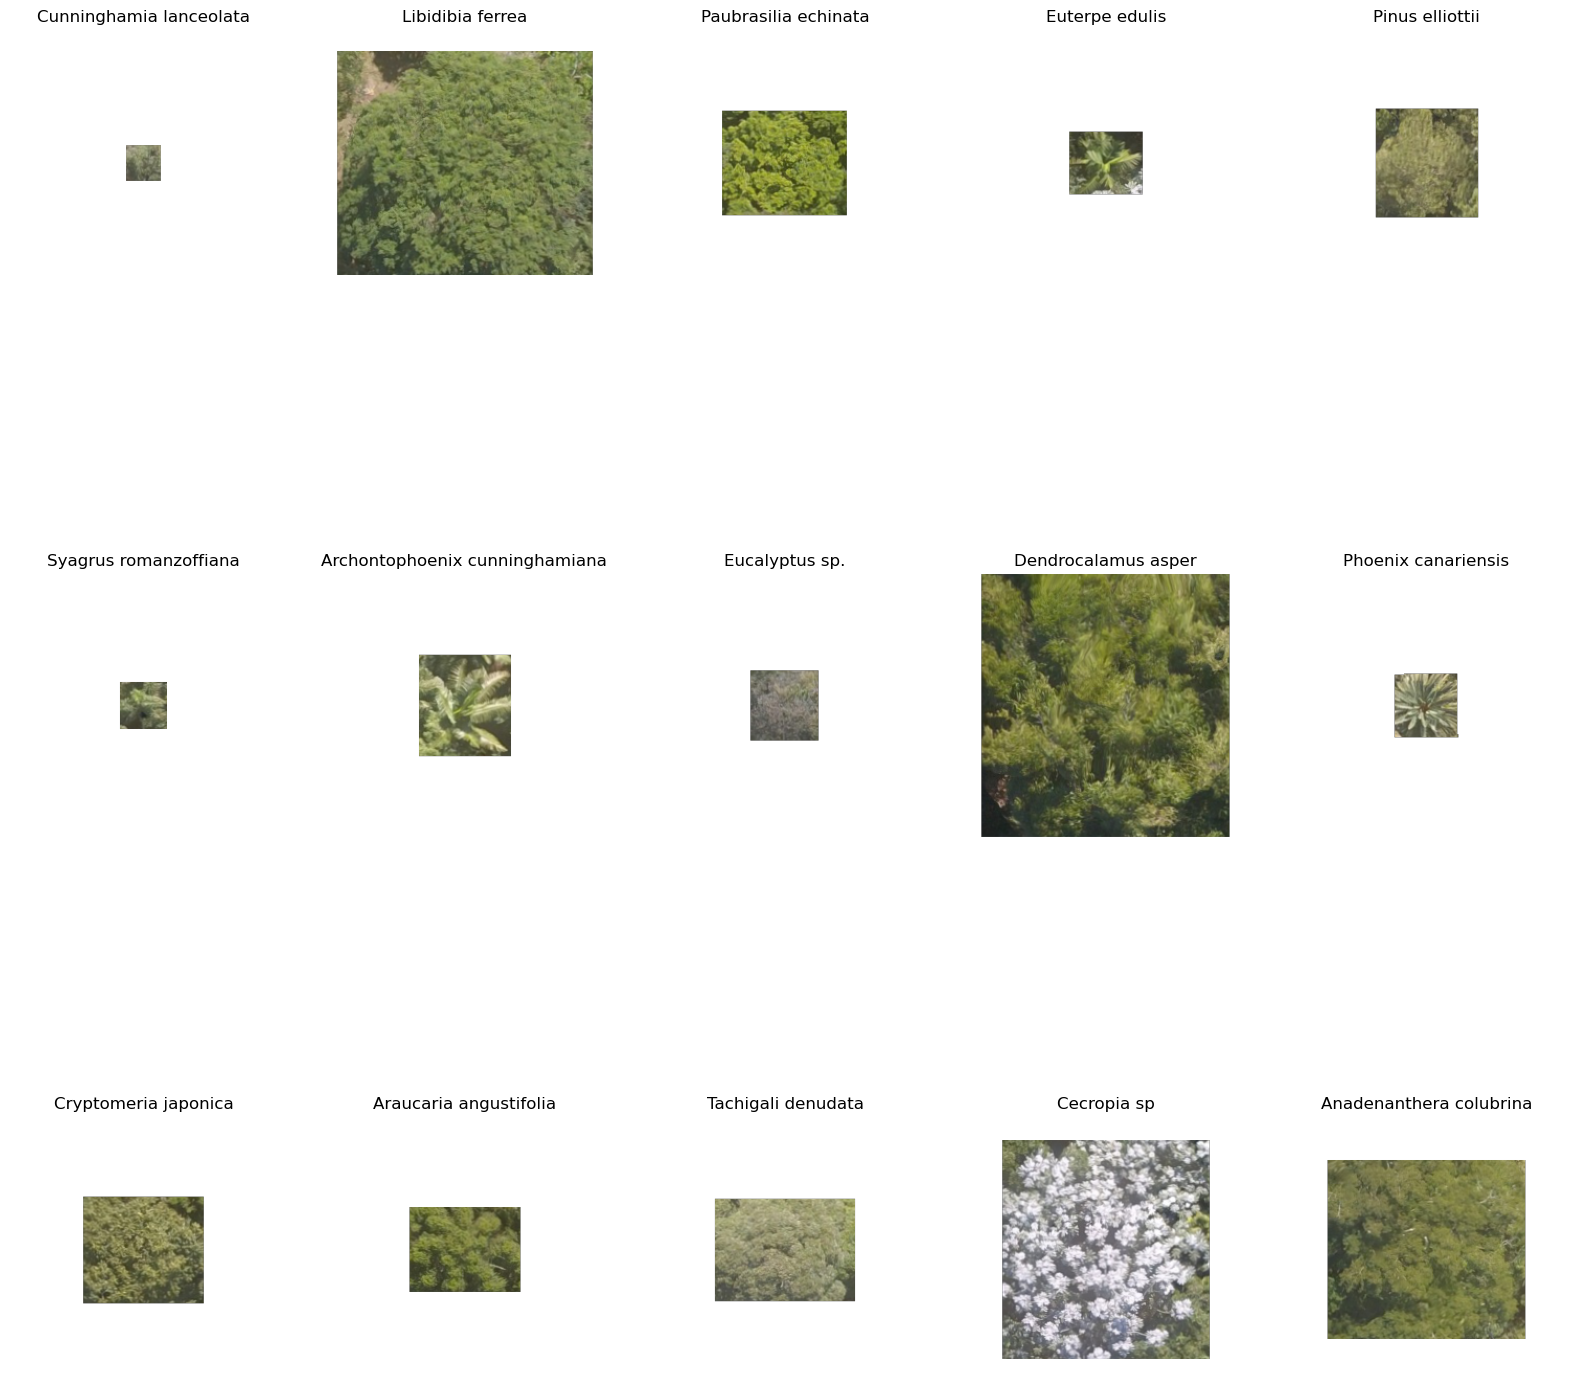

In [59]:
# Visualize one samples per unique label from cutouts
# five samples per row
num_unique_labels = len(unique_labels)
num_samples_per_row = 5
num_samples_per_col = math.ceil(num_unique_labels / num_samples_per_row)
fig, axs = plt.subplots(num_samples_per_col, num_samples_per_row, figsize=(20, 20))
for i, label in enumerate(unique_labels):
    row = i // num_samples_per_row
    col = i % num_samples_per_row
    sample = cutouts[labels == label][0]
    axs[row, col].imshow(sample)
    axs[row, col].set_title(f'{id_species_mapping[label]["ESPECIE"]}')
    axs[row, col].axis('off')

In [60]:
# create a Dataset and add cutouts and labels to it
ds = xr.Dataset(
    data_vars={
        'X': (['sample', 'x', 'y', 'channel'], cutouts),
        'Y': (['sample'], labels),
    },
    attrs=id_species_mapping
)
ds = ds.isel(channel=range(3))
ds

<xarray.Dataset>
Dimensions:  (sample: 102, x: 256, y: 256, channel: 3)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Y        (sample) int64 91277344256 91277344256 ... 997207531008
Attributes: (12/15)
    91277344256:   {'ESPECIE': 'Cunninghamia lanceolata', 'TIPO': 'exotica in...
    100373655296:  {'ESPECIE': 'Libidibia ferrea', 'TIPO': 'nativa do Brasil'}
    143965381632:  {'ESPECIE': 'Paubrasilia echinata', 'TIPO': 'nativa do Bra...
    236959227904:  {'ESPECIE': 'Euterpe edulis', 'TIPO': 'nativa ameaçada de ...
    245146887168:  {'ESPECIE': 'Pinus elliottii', 'TIPO': 'exotica invasora'}
    267652544512:  {'ESPECIE': 'Syagrus romanzoffiana', 'TIPO': 'nativa'}
    ...            ...
    742456632832:  {'ESPECIE': 'Phoenix canariensis', 'TIPO': 'exotica'}
    762290529280:  {'ESPECIE': 'Cryptomeria japonica', 'TIPO': 'exotica'}
    867124054528:  {'ESPECIE': 'Araucaria angustifolia', 'TIPO': 'ameacada'}
    912749161984:  {'ESPECIE': 'Tachigali denudata', 'TIPO': 'nativa ameaçada...
    928764938240:  {'ESPECIE': 'Cecropia sp', 'TIPO': 'nativa'}
    997207531008:  {'ESPECIE': 'Anadenanthera colubrina', 'TIPO': 'nativa'}

In [61]:
# save the Dataset in Zarr format
ds_path = data_path / 'Tree_labels_merged' / 'tree_labels_merged.zarr'
ds.to_zarr(ds_path, mode='w')

## Statistics of the selected cutouts

In [62]:
ds = xr.open_zarr(ds_path)
ds

<xarray.Dataset>
Dimensions:  (sample: 102, x: 256, y: 256, channel: 3)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) uint8 dask.array<chunksize=(26, 128, 128, 2), meta=np.ndarray>
    Y        (sample) int64 dask.array<chunksize=(102,), meta=np.ndarray>
Attributes: (12/15)
    100373655296:  {'ESPECIE': 'Libidibia ferrea', 'TIPO': 'nativa do Brasil'}
    143965381632:  {'ESPECIE': 'Paubrasilia echinata', 'TIPO': 'nativa do Bra...
    236959227904:  {'ESPECIE': 'Euterpe edulis', 'TIPO': 'nativa ameaçada de ...
    245146887168:  {'ESPECIE': 'Pinus elliottii', 'TIPO': 'exotica invasora'}
    267652544512:  {'ESPECIE': 'Syagrus romanzoffiana', 'TIPO': 'nativa'}
    318213318656:  {'ESPECIE': 'Archontophoenix cunninghamiana', 'TIPO': 'exo...
    ...            ...
    762290529280:  {'ESPECIE': 'Cryptomeria japonica', 'TIPO': 'exotica'}
    867124054528:  {'ESPECIE': 'Araucaria angustifolia', 'TIPO': 'ameacada'}
    912749161984:  {'ESPECIE': 'Tachigali denudata', 'TIPO': 'nativa ameaçada...
    91277344256:   {'ESPECIE': 'Cunninghamia lanceolata', 'TIPO': 'exotica in...
    928764938240:  {'ESPECIE': 'Cecropia sp', 'TIPO': 'nativa'}
    997207531008:  {'ESPECIE': 'Anadenanthera colubrina', 'TIPO': 'nativa'}

In [213]:
# Loop through the sample dimension and remove padded zeros
imgs = []
widths = []
heights = []
for i in range(ds['X'].sizes['sample']):
    img = ds['X'].isel(sample=i).values
    img = img[~(img == 0).all(axis=(0, 2))]
    idx = np.nonzero(~((img == 0).all(axis=(0,2))))
    img = img[:, idx[0], :]
    imgs.append(img)
    widths.append(img.shape[1])
    heights.append(img.shape[0])

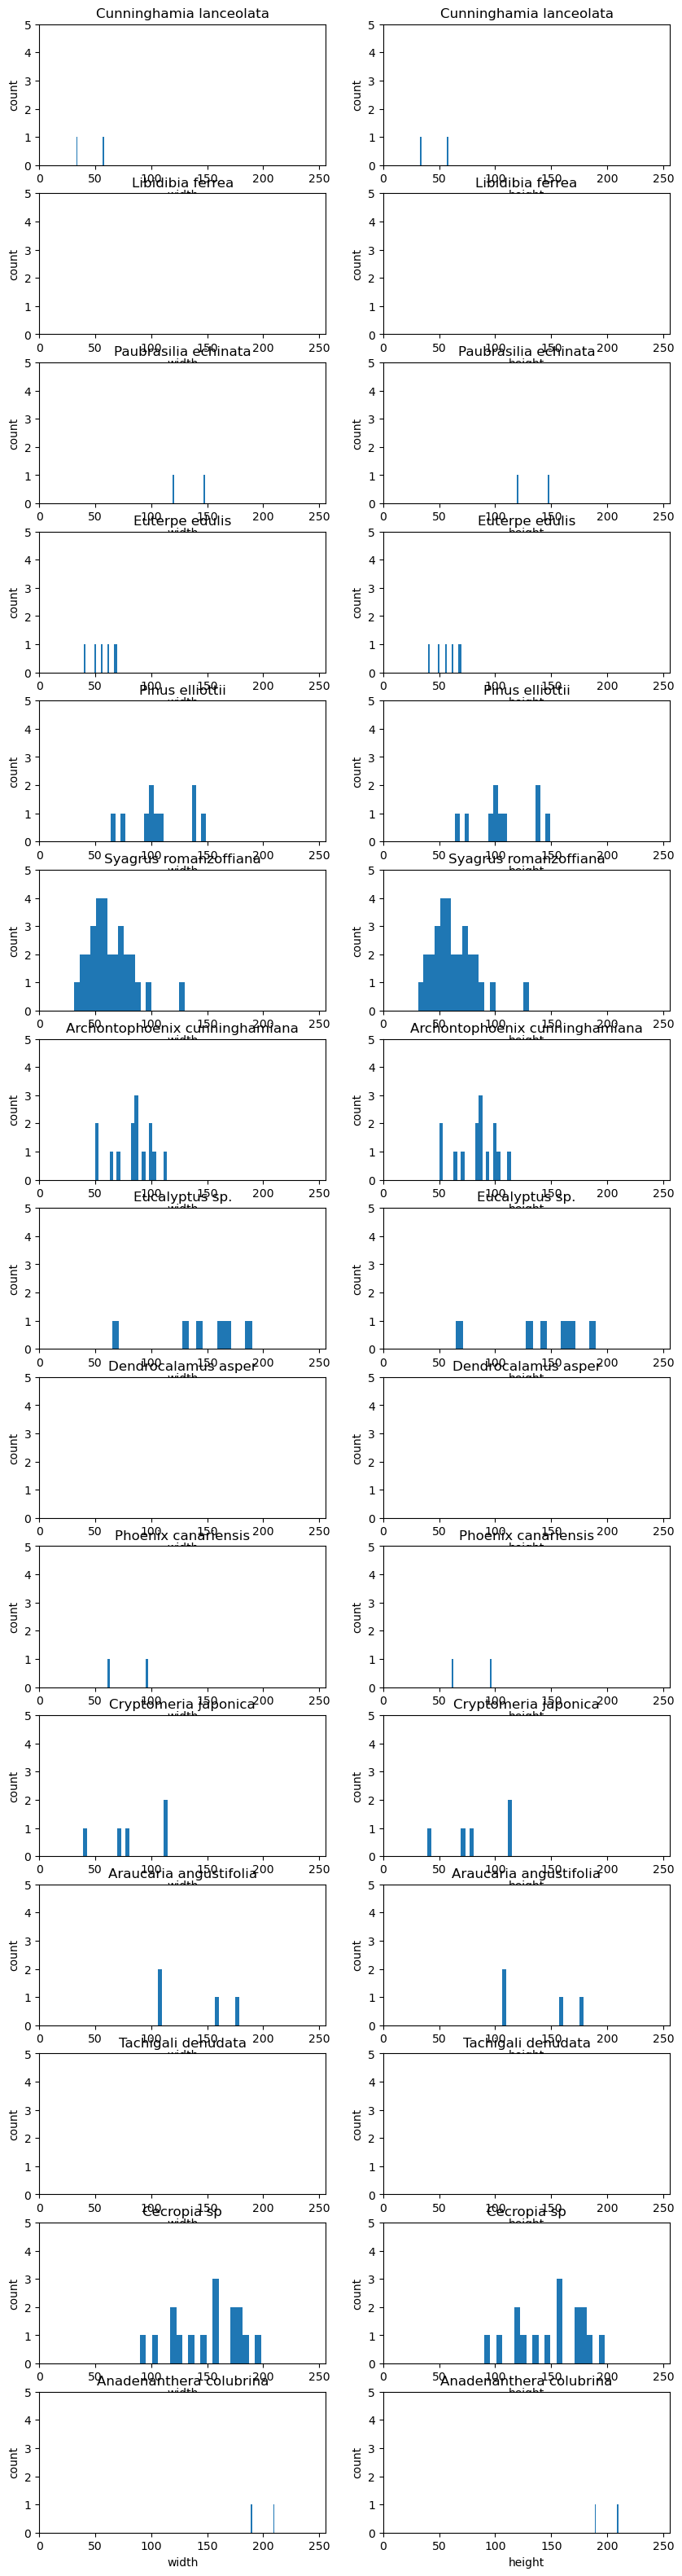

In [270]:
# width histogram, group by ds['Y']
widths = np.array(widths)
heights = np.array(heights)
labels = ds['Y'].values
unique_labels = np.unique(labels)
num_unique_labels = len(unique_labels)
fig, axs = plt.subplots(num_unique_labels, 2, figsize=(10, 40))
for i, label in enumerate(unique_labels):
    mask = labels == label
    axs[i, 0].hist(widths[mask], bins=20)
    axs[i, 0].set_title(f'{id_species_mapping[label]["ESPECIE"]}')
    axs[i, 0].set_xlabel('width')
    axs[i, 0].set_ylabel('count')
    axs[i, 1].hist(heights[mask], bins=20)
    axs[i, 1].set_title(f'{id_species_mapping[label]["ESPECIE"]}')
    axs[i, 1].set_xlabel('height')
    axs[i, 1].set_ylabel('count')
# set x and y limits
for ax in axs.flatten():
    ax.set_xlim([0, 256])
    ax.set_ylim([0, 5])



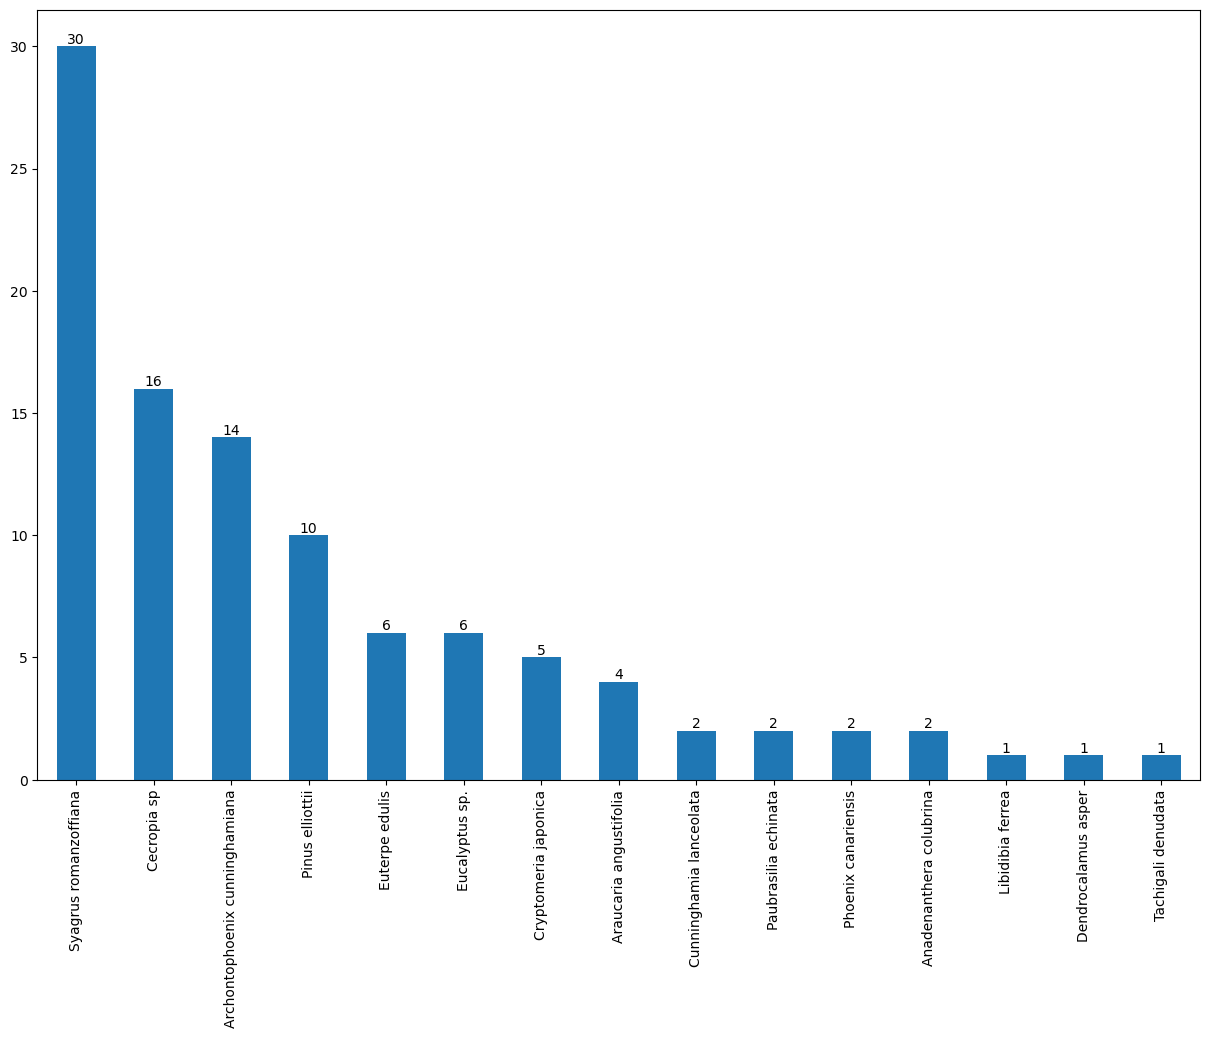

In [266]:
# Count the number of samples per species and plot the histogram
species_counts = ds['Y'].to_pandas().value_counts()
# update index with species names
species_counts.index = species_counts.index.map(lambda x: id_species_mapping[x]['ESPECIE'])
species_counts = species_counts.sort_values(ascending=False)
species_counts.plot(kind='bar', figsize=(15, 10))
# Add the count to the plot
for i, count in enumerate(species_counts):
    plt.text(i, count, count, ha='center', va='bottom')

ToDo: after cutout and resampling, is there a corr between the image size and species?
Number of samples per species?
Exclude the species with strong corr to sumber of samples
Target: 10~15 classes with the size around 128x128

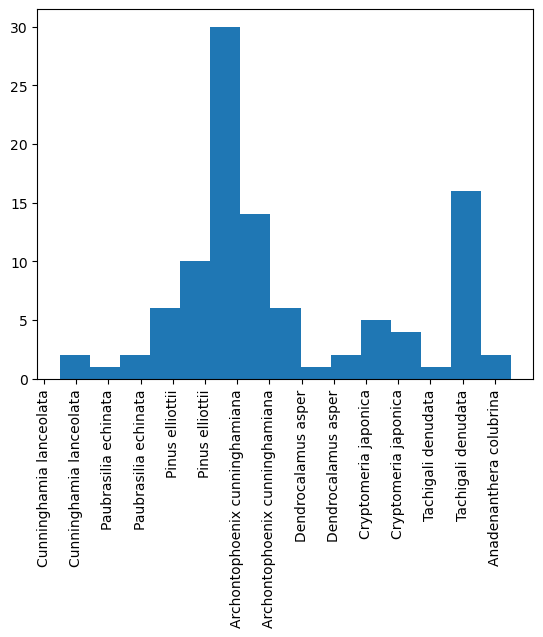

In [246]:
# Make a histogram of species
# replace the ID with the species name
species = [id_species_mapping[s]['ESPECIE'] for s in ds['Y'].values]
# species = np.array(species)
plt.hist(species, bins=np.unique(species).shape[0])
plt.xticks(rotation=90)
# center the xticks
plt.gca().set_xticks(np.arange(len(np.unique(species)))-0.5)